In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from ladybug.sunpath import Sunpath

import oshe as tc


Failed to load paths from C:\Users\tgerrish\Miniconda3\lib\site-packages\honeybee\config.json.
Path to radiance is set to: c:/radiance


# Inputs

In [2]:
idd_file = r"C:\openstudio-2.7.0\EnergyPlus\Energy+.idd"
epw_file = r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\UWG_ARE_AZ_Abu.Dhabi-Bateen.Exec.AP.412160_TMYx_URBAN_02.epw"

# Load weatherfile data

In [3]:
# Load epw
epw = EPW(epw_file)

# Get climate variables
dbt = np.array(epw.dry_bulb_temperature.values)
rh = np.array(epw.relative_humidity.values)
ws = np.array(epw.wind_speed.values)
hir = np.array(epw.horizontal_infrared_radiation_intensity.values)

# Calculate hourly solar altitudes and hir for input
sun_path = Sunpath.from_location(epw.location)
sun_altitude = np.array([sun_path.calculate_sun_from_hoy(i).altitude for i in range(8760)])

# Open-field MRT and UTCI calculation

In [4]:
# Define ground material
gnd_mat = tc.material.material_dict["CONCRETE"]
ground_zone = tc.geometry.Ground(gnd_mat, xy=5, depth=1.5, subsurface_size=5)

# Calculate ground surface temperature
of_srf_temp = tc.energyplus.run_energyplus(epw_file, idd_file, ground=ground_zone, shades=None, run=True)

# Calculate incident solar direct and diffuse radiation
of_dir_rad, of_dif_rad = tc.radiance.run_radiance(epw_file, ground=ground_zone, shades=None, run=True)

# Calculate MRT
of_mrt = tc.mrt.mean_radiant_temperature(surrounding_surfaces_temperature=of_srf_temp[0], horizontal_infrared_radiation_intensity=hir, diffuse_horizontal_solar=of_dif_rad.T[0], direct_normal_solar=of_dir_rad.T[0], sun_altitude=sun_altitude, ground_reflectivity=gnd_mat.reflectivity, sky_exposure=1, radiance=True)[0]

# Calculate UTCI
of_utci = tc.utci.universal_thermal_climate_index(dbt, of_mrt, ws, rh)

Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.09 seconds]
Universal thermal climate index calculated [0.11 seconds]


# Post-process Rhino/GH case

In [5]:
# Load case recipe
recipe = "./projects/EXAMPLE/recipe.json"
reload = False

# Create output directory for generated images
output_directory = os.path.dirname(os.path.dirname(recipe))
plot_directory = os.path.join(os.path.dirname(recipe), "plots")
if not os.path.exists(plot_directory):
    os.mkdir(plot_directory)

# Load JSON
d = tc.helpers.load_json(recipe)

# Load surface view factors
surface_view_factors = np.array(d["surface_view_factors"])

# Load sky view factors
sky_view_factors = np.array([[i] for i in d["sky_view_factors"]]) / 100 * 0.5

# Load ground reflectivities
ground_reflectivities = np.array([[i] for i in d["ground_reflectivities"]])

# Load plot tricontour plot 
boundary = np.array(d["boundary"])[:, :-1]

# Load points
points = np.array(d["points"])

if not reload:
    # Read EnergyPlus annual hourly surface temperature results
    surface_temperatures = tc.helpers.load_energyplus_results(d["eplus_results"])

    # Read Radiance simulation annual hourly incident radiation results
    radiation_direct, radiation_diffuse = tc.helpers.load_radiance_results(d["radiation_results"])
    
    # Calculate generic sky temperature
    skytemp = tc.oshe.sky_temperature(hir)

    # Append sky temperature and air temperature onto end of surface temperatures
    all_srf_temps = np.vstack([surface_temperatures, skytemp, dbt])

    # Append sky view factor to end of surface view factors
    all_vfs = np.hstack([surface_view_factors, sky_view_factors])

    # Add view factor to end of each group, bringing total to 1
    makeups = np.where(1 - all_vfs.sum(axis=1) <= 0, 0, 1 - all_vfs.sum(axis=1))
    all_vfs = np.vstack([all_vfs.T, makeups]).T

    # Normalise view factors to 0-1
    all_vfs = all_vfs.T * (1 / all_vfs.sum(axis=1))

    # Calculate overall surrounding surface temperature using view factors and individual surface temperatures
    surrounding_surface_temperatures = np.power(np.matmul(all_vfs.T, np.power(all_srf_temps.T + 273.15, 4).T), 0.25) - 273.15
    print("View-factored surface temperatures calculated")
    

EnergyPlus results loaded
Radiance results loaded
View-factored surface temperatures calculated


# Calculate MRT and write to file

In [6]:
mrt_path = os.path.join(os.path.dirname(recipe), "result.mrt")
if not reload:
    mean_radiant_temperature = tc.mrt.mrt_parallel(
        threads=8, 
        surrounding_surfaces_temperature=surrounding_surface_temperatures, 
        horizontal_infrared_radiation_intensity=hir, 
        diffuse_horizontal_solar=radiation_diffuse, 
        direct_normal_solar=radiation_direct, 
        sun_altitude=sun_altitude, 
        ground_reflectivity=ground_reflectivities, 
        sky_exposure=sky_view_factors, 
        radiance=True
    )

    # Write to file
    df_mrt = pd.DataFrame(mean_radiant_temperature.T)
    df_mrt.round(6).to_csv(mrt_path, index=False)
    print("MRT calculated and written to {}".format(mrt_path))
else:
    mean_radiant_temperature = pd.read_csv(mrt_path).values.T
    print("MRT reloaded from {}".format(mrt_path))

MRT calculated and written to ./projects/EXAMPLE\result.mrt


# Calculate UTCI and write to file

In [7]:
utci_path = os.path.join(os.path.dirname(recipe), "result.utci")
if not reload:
    universal_thermal_climate_index = tc.utci.utci_parallel(
        threads=8, 
        air_temperature=dbt, 
        mean_radiant_temperature=mean_radiant_temperature.T, 
        wind_speed=ws, 
        relative_humidity=rh
    )

    # Write to file
    df_utci = pd.DataFrame(universal_thermal_climate_index.T)
    df_utci.round(6).to_csv(utci_path, index=False)
    print("UTCI calculated and written to {}".format(utci_path))
else:
    universal_thermal_climate_index = pd.read_csv(utci_path).values.T
    print("UTCI reloaded from {}".format(utci_path))

UTCI calculated and written to ./projects/EXAMPLE\result.utci


# Construct results object

In [231]:
utci = tc.plot2.UTCI(of_utci, universal_thermal_climate_index, points)

# Plot the charts

In [12]:
rad_files = [
    r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\EXAMPLE\gridbased_annual\scene\glazing\EXAMPLE..glz.rad",
    r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\EXAMPLE\gridbased_annual\scene\opaque\EXAMPLE..opq.rad"
]
focus_pts = [0, 1]

utci.generate_plots(rad_files, focus_pts, boundary, plot_directory)

Plot saved to ./projects/EXAMPLE\plots\openfield_comfortheatmap.png
Plot saved to ./projects/EXAMPLE\plots\context.png
Plot saved to ./projects/EXAMPLE\plots\context_ptlabel.png
Plot saved to ./projects/EXAMPLE\plots\context_focuspts.png
Plot saved to ./projects/EXAMPLE\plots\improvement_annual_morningshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_annual_afternoonshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_annual_morningafternoonshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_may_morningshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_may_afternoonshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_may_morningafternoonshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_october_morningshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_october_afternoonshoulder.png
Plot saved to ./projects/EXAMPLE\plots\improvement_october_morningafternoonshoulder.png
Plot saved to ./projects/EXAMPLE\

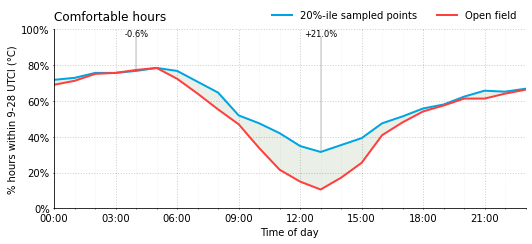

In [276]:

utci.plot_comfortable_hours(months=[1, 2, 3, 4, 5, 6], percentile=0.2, close=False)

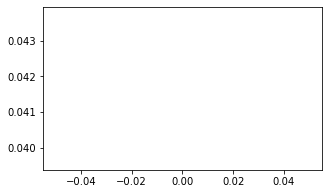

In [96]:
import matplotlib.pyplot as plt
# utci.comfort_in_period(mask=utci.mask_may)

percentile = 0.95
lower = 9
upper = 28
months = [12]
utci_values = utci.utci_openfield

# Create month of year mask and number of potential values
mask = utci.index.month.isin(months)
count = mask.sum()

# Find the number of hours in comfort range in selected dataframe, and calculate percentage comfort in 
temp = utci_values[mask]
temp = ((temp >= lower) & (temp <= upper)).groupby(temp.index.hour).sum()
try:
    temp = temp.quantile(percentile, axis=1) / count
except Exception as e:
    temp = temp.quantile(percentile) / count

# temp
# Calculate 
# 
# count = mask.sum()
# temp = values[mask]
# ((temp >= lower) & (temp <= upper)).groupby(temp.index.hour).sum().quantile(percentile, axis=1) / mask.sum()


fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(temp)